In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split


In [26]:
!pip install keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [5]:
df = pd.read_csv("creditcard.csv")

In [6]:
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.shape

(284807, 31)

In [8]:
df.isnull().values.any()

False

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


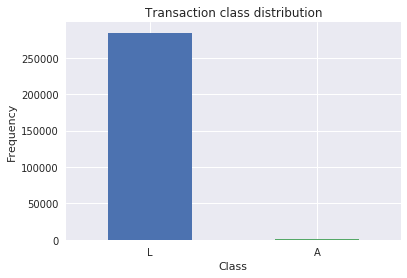

In [10]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2),'LABELS')
plt.xlabel("Class")
plt.ylabel("Frequency");

In [11]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [12]:
frauds.shape

(492, 31)

In [13]:
normal.shape

(284315, 31)

In [14]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [15]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


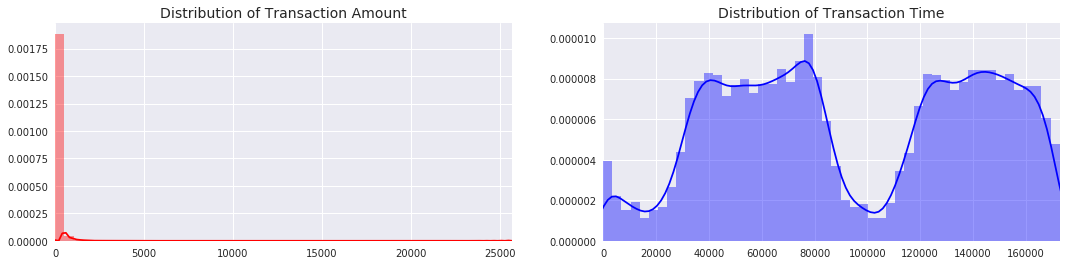

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


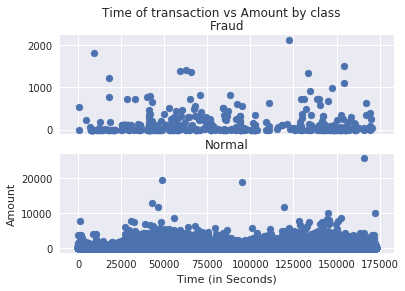

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


In [25]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [28]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

In [31]:
#building the model

input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)


In [32]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 12s 52us/step - loss: 0.8115 - acc: 0.5884 - val_loss: 0.7857 - val_acc: 0.6501
Epoch 2/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.7461 - acc: 0.6519 - val_loss: 0.7686 - val_acc: 0.6567
Epoch 3/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7361 - acc: 0.6564 - val_loss: 0.7647 - val_acc: 0.6559
Epoch 4/100
227451/227451 [==============================] - 11s 46us/step - loss: 0.7316 - acc: 0.6611 - val_loss: 0.7618 - val_acc: 0.6566
Epoch 5/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7290 - acc: 0.6626 - val_loss: 0.7636 - val_acc: 0.6635
Epoch 6/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7271 - acc: 0.6629 - val_loss: 0.7599 - val_acc: 0.6555
Epoch 7/100
227451/227451 [==============================] - 11s 46us/step - loss: 0.7256 - acc: 0.6630

In [33]:
autoencoder = load_model('model.h5')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


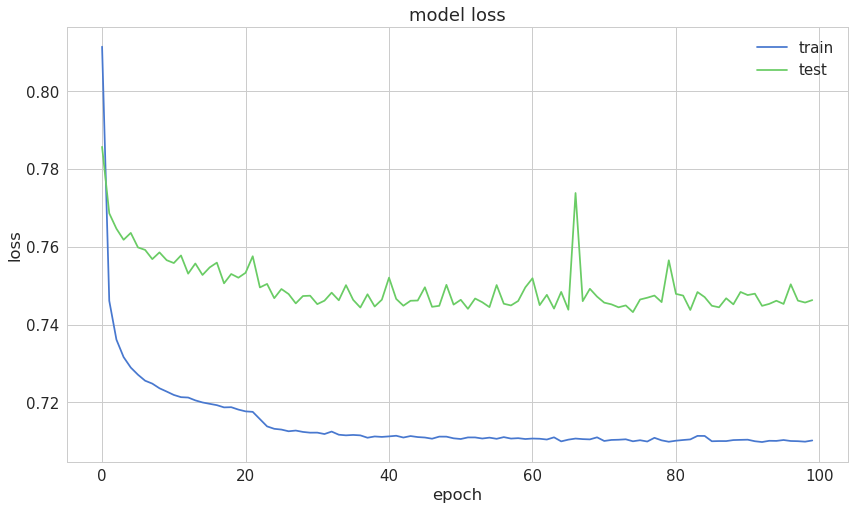

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [35]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.736631,0.001720
std,3.403988,0.041443
min,0.045184,0.000000
25%,0.243080,0.000000
50%,0.390607,0.000000
75%,0.619684,0.000000
max,259.520577,1.000000


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


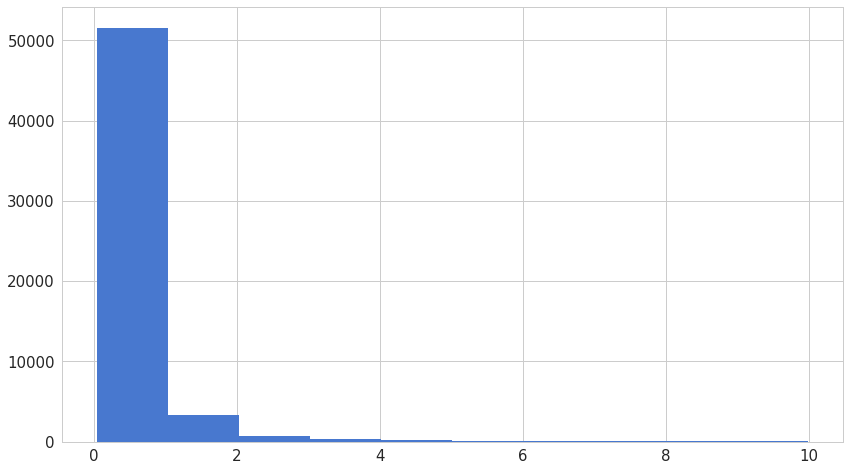

In [36]:
#reconstruction error  without fraud

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


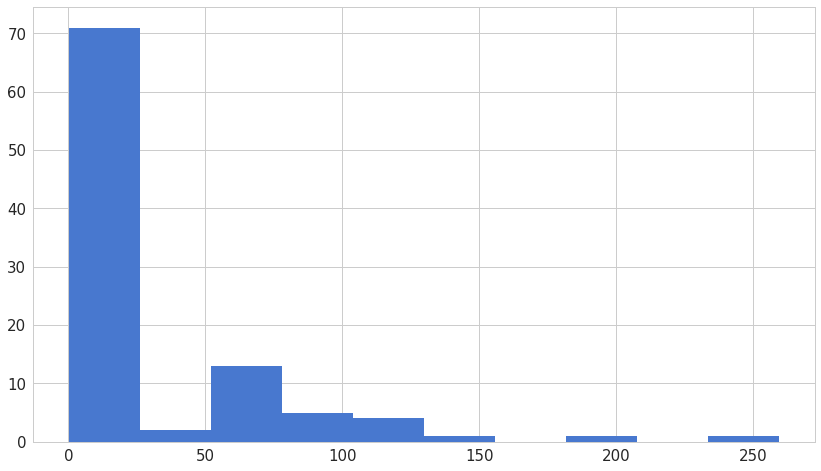

In [37]:
#reconstruction error with fraud
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [38]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


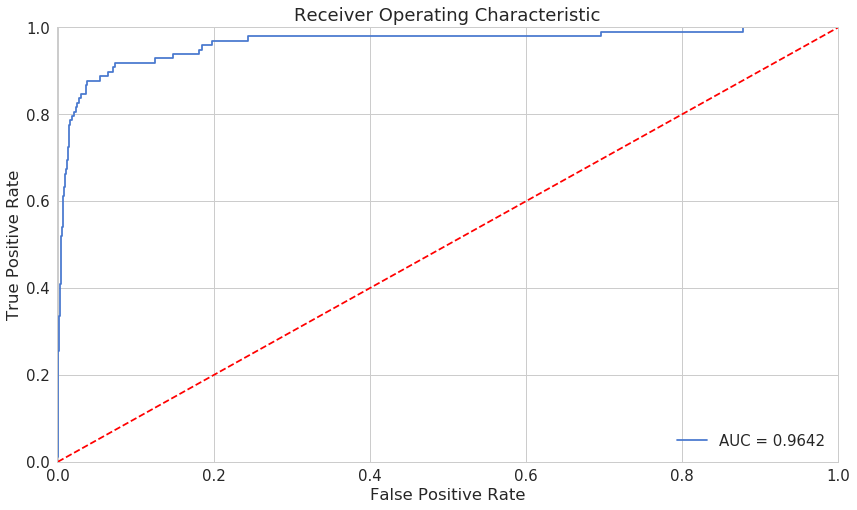

In [39]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


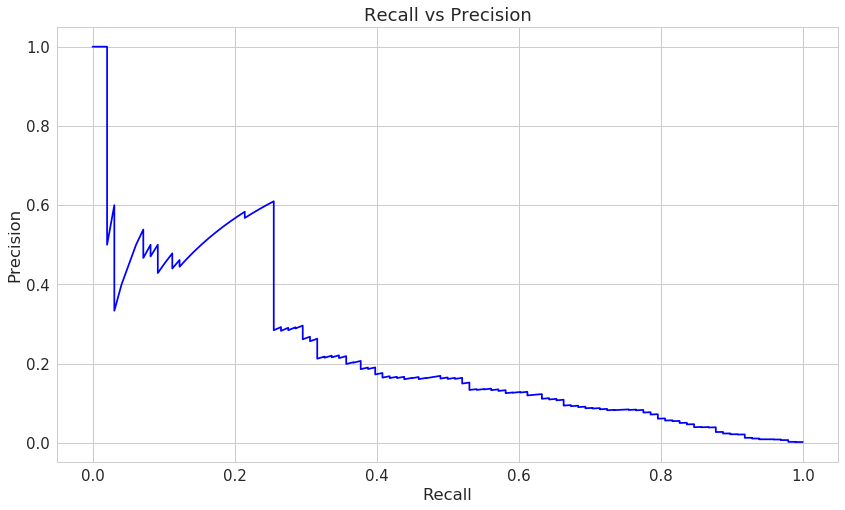

In [40]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


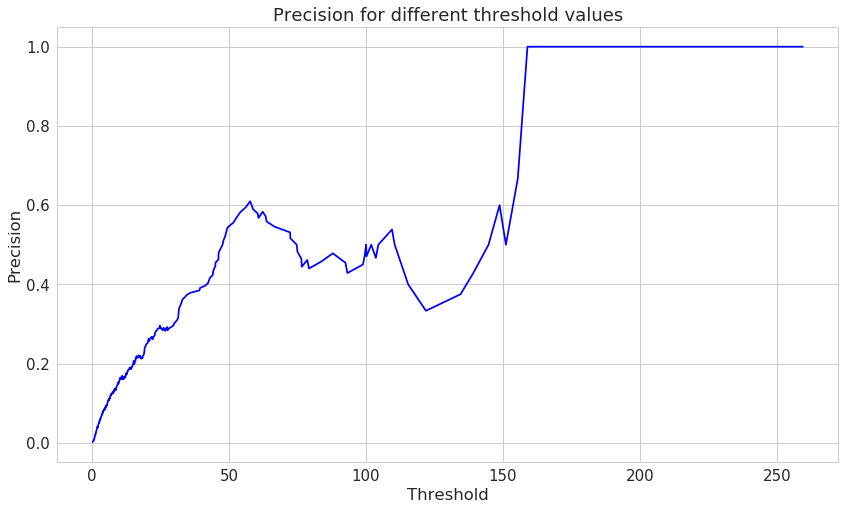

In [41]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


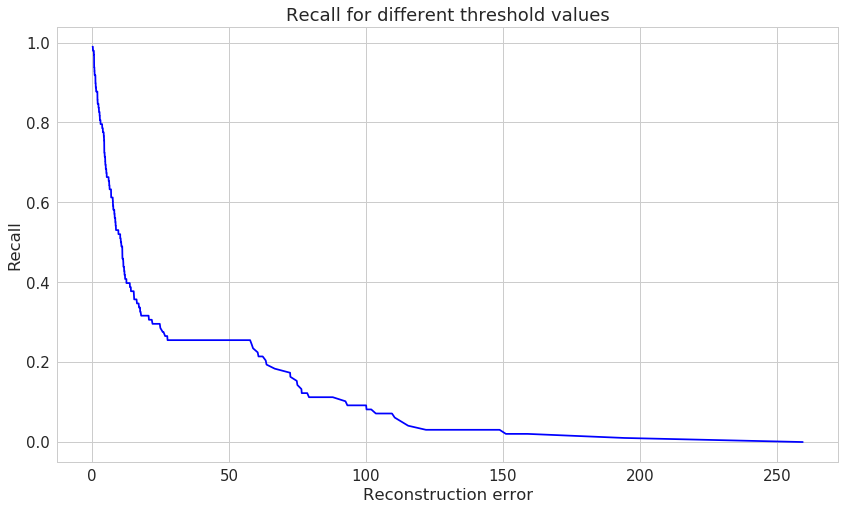

In [42]:

plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


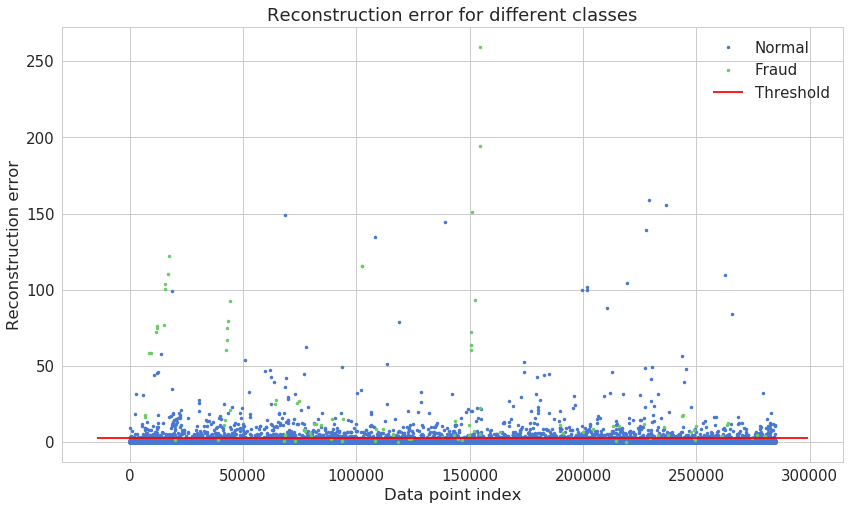

In [43]:
threshold = 2.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


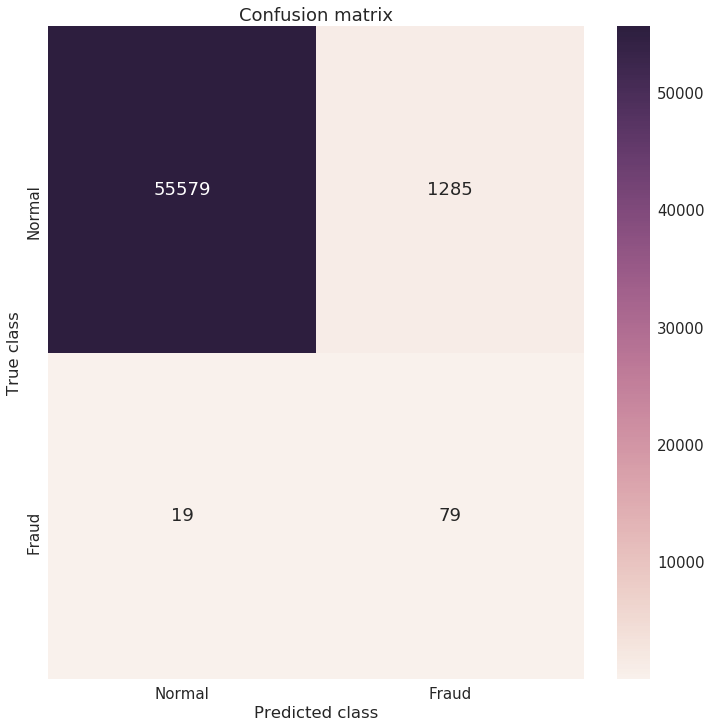

In [44]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


E_Data=pd.read_csv("creditcard.csv")
E_Data.dropna(thresh=284315)
E_Train_Data=E_Data
E_Target=E_Train_Data['Class']
E_Train_Data.drop('Class',axis=1,inplace=True)
x_train,x_test,y_train,y_test=train_test_split(E_Train_Data,E_Target,test_size=0.5,random_state=0)

In [46]:
clf_E = RandomForestClassifier(max_depth=2, random_state=0)
clf_E.fit(x_train, y_train)
print(classification_report(y_test,clf_E.predict(x_test)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    142161
          1       0.85      0.53      0.65       243

avg / total       1.00      1.00      1.00    142404



In [47]:
from sklearn.cluster import KMeans
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
X = E_Train_Data
y = E_Target

X_scaled = scale(X)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.33, random_state=500)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


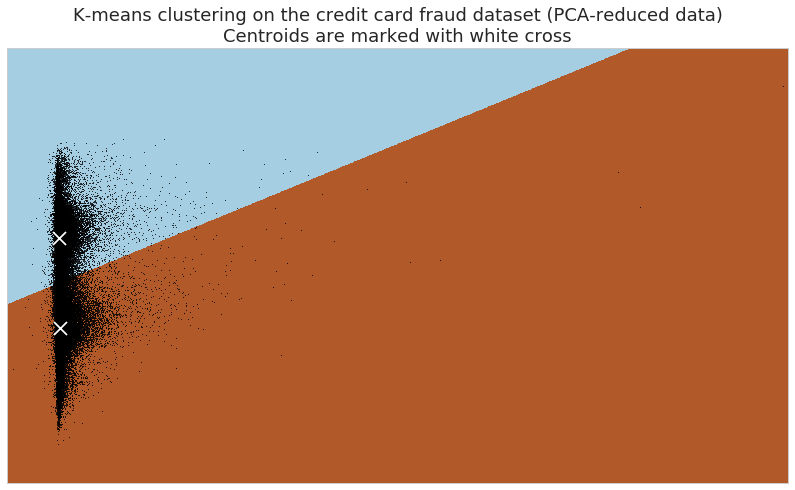

In [48]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_reduced[:, 0], X_reduced[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the credit card fraud dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [49]:
predictions = kmeans.predict(X_test)

pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y_test == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))

pred_good = np.where(predictions == 0)[0]
real_good = np.where(y_test == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))

false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(X_test) - (false_neg + false_pos)) / len(X_test)
print("Accuracy:", accuracy)
print("False negative rate (with respect to misclassifications): ", false_neg_rate)
print("False negative rate (with respect to all the data): ", false_neg / len(predictions))
print("False negatives, false positives, mispredictions:", false_neg, false_pos, false_neg + false_pos)
print("Total test data points:", len(X_test))

Accuracy: 0.452913700830966
False negative rate (with respect to misclassifications):  0.0011279877088235866
False negative rate (with respect to all the data):  0.000617106621128454
False negatives, false positives, mispredictions: 58 51361 51419
Total test data points: 93987


In [51]:
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures
X = E_Train_Data
y = E_Target
print("X and y sizes, respectively:", len(X), len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)
print("Train and test sizes, respectively:", len(X_train), len(y_train), "|", len(X_test), len(y_test))
print("Total number of frauds:", len(y.loc[E_Target == 1]), len(y.loc[E_Target== 1])/len(y))
print("Number of frauds on y_test:", len(y_test.loc[E_Target == 1]), len(y_test.loc[E_Target == 1]) / len(y_test))
print("Number of frauds on y_train:", len(y_train.loc[E_Target == 1]), len(y_train.loc[E_Target == 1])/len(y_train))


X and y sizes, respectively: 284807 284807
Train and test sizes, respectively: 185124 185124 | 99683 99683
Total number of frauds: 492 0.001727485630620034
Number of frauds on y_test: 183 0.0018358195479670557
Number of frauds on y_train: 309 0.00166915148765152


In [52]:
!pip install imblearn
!pip install --upgrade sklearn

    100% |████████████████████████████████| 174kB 6.9MB/s ta 0:00:01
    100% |████████████████████████████████| 6.6MB 3.4MB/s eta 0:00:01    98% |███████████████████████████████▌| 6.5MB 29.8MB/s eta 0:00:01
    100% |████████████████████████████████| 286kB 22.5MB/s ta 0:00:01
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1
  Running setup.py bdist_wheel for sklearn ... done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [53]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import random

logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(X_train, y_train)
print("Score: ", logistic.score(X_test, y_test))

Score:  0.9988363111062066


In [54]:
y_predicted = np.array(logistic.predict(X_test))
y_right = np.array(y_test)
print()


In [55]:
!pip install pandas-ml

    100% |████████████████████████████████| 102kB 4.5MB/s a 0:00:011


In [56]:
from pandas_ml import ConfusionMatrix
import pandas_ml as pdml

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False      99476    24    99500
True          92    91      183
__all__    99568   115    99683


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


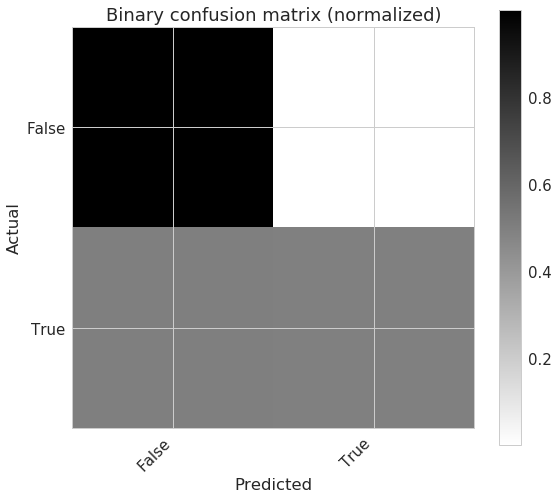

population: 99683
P: 183
N: 99500
PositiveTest: 115
NegativeTest: 99568
TP: 91
TN: 99476
FP: 24
FN: 92
TPR: 0.4972677595628415
TNR: 0.9997587939698492
PPV: 0.7913043478260869
NPV: 0.9990760083560983
FPR: 0.00024120603015075377
FDR: 0.20869565217391303
FNR: 0.5027322404371585
ACC: 0.9988363111062066
F1_score: 0.610738255033557
MCC: 0.6267695145850444
informedness: 0.49702655353269076
markedness: 0.7903803561821854
prevalence: 0.0018358195479670557
LRP: 2061.589253187614
LRN: 0.5028535317412971
DOR: 4099.780797101449
FOR: 0.0009239916439016552


In [57]:
confusion_matrix = ConfusionMatrix(y_right, y_predicted)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot(normalized=True)
plt.show()
confusion_matrix.print_stats()

In [58]:
print("FNR is {0}".format(confusion_matrix.stats()['FNR']))

FNR is 0.5027322404371585


In [59]:
df2 = pdml.ModelFrame(X_train, target=y_train)
sampler = df2.imbalance.over_sampling.SMOTE()
sampled = df2.fit_sample(sampler)
print("Size of training set after over sampling:", len(sampled))

Size of training set after over sampling: 369630


In [60]:
X_train_sampled = sampled.iloc[:,1:]
y_train_sampled = sampled['Class']

# NOTE: Scaling makes it worse.
# X_train_sampled = scale(X_train_sampled)

logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(X_train_sampled, y_train_sampled)
print("Score: ", logistic.score(X_test, y_test))

Score:  0.9823741259793546


Confusion matrix:
Predicted  False  True  __all__
Actual                         
False      97762  1738    99500
True          19   164      183
__all__    97781  1902    99683


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


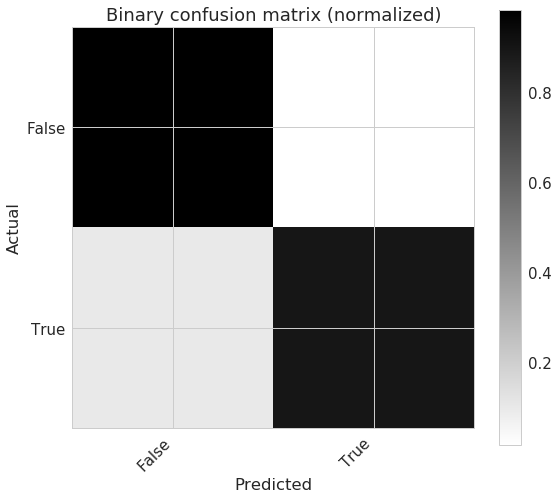

population: 99683
P: 183
N: 99500
PositiveTest: 1902
NegativeTest: 97781
TP: 164
TN: 97762
FP: 1738
FN: 19
TPR: 0.8961748633879781
TNR: 0.982532663316583
PPV: 0.08622502628811778
NPV: 0.9998056882216382
FPR: 0.017467336683417087
FDR: 0.9137749737118822
FNR: 0.10382513661202186
ACC: 0.9823741259793546
F1_score: 0.15731414868105514
MCC: 0.27494697010058833
informedness: 0.8787075267045612
markedness: 0.08603071450975586
prevalence: 0.0018358195479670557
LRP: 51.30575311110692
LRN: 0.10567092625862988
DOR: 485.52383259645086
FOR: 0.00019431177836184944


In [61]:
y_predicted1 = np.array(logistic.predict(X_test))
y_right1 = np.array(y_test)

confusion_matrix1 = ConfusionMatrix(y_right1, y_predicted1)
print("Confusion matrix:\n%s" % confusion_matrix1)
confusion_matrix1.plot(normalized=True)
plt.show()
confusion_matrix1.print_stats()

In [62]:
print("FNR is {0}".format(confusion_matrix1.stats()['FNR']))

FNR is 0.10382513661202186


In [63]:
best_c, best_fnr = 1, 1
for _ in range(20):
    c = random.uniform(1, 10000)
    logistic = linear_model.LogisticRegression(C=c, class_weight="balanced")
    logistic.fit(X_train, y_train)
    print("Score: ", logistic.score(X_test, y_test))
   

Score:  0.9737969362880331
Score:  0.9737768726864159
Score:  0.9737768726864159
Score:  0.9738069680888416
Score:  0.9737668408856074
Score:  0.9738069680888416
Score:  0.9738069680888416
Score:  0.9737768726864159
Score:  0.9737869044872245
Score:  0.9737969362880331
Score:  0.9737768726864159
Score:  0.9737869044872245
Score:  0.9737768726864159
Score:  0.9737969362880331
Score:  0.9738069680888416
Score:  0.9737768726864159
Score:  0.9737668408856074
Score:  0.9737768726864159
Score:  0.9737869044872245
Score:  0.9737668408856074


Confusion matrix:
Predicted  False  True  __all__
Actual                         
False      96900  2600    99500
True          15   168      183
__all__    96915  2768    99683


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


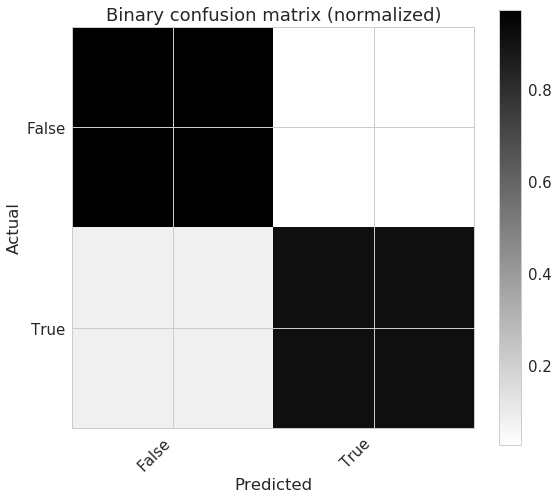

population: 99683
P: 183
N: 99500
PositiveTest: 2768
NegativeTest: 96915
TP: 168
TN: 96900
FP: 2600
FN: 15
TPR: 0.9180327868852459
TNR: 0.9738693467336683
PPV: 0.06069364161849711
NPV: 0.9998452251973379
FPR: 0.02613065326633166
FDR: 0.9393063583815029
FNR: 0.08196721311475409
ACC: 0.9737668408856074
F1_score: 0.11385970857336496
MCC: 0.2323676924185342
informedness: 0.8919021336189141
markedness: 0.06053886681583487
prevalence: 0.0018358195479670557
LRP: 35.132408575031526
LRN: 0.08416653978243584
DOR: 417.41538461538465
FOR: 0.00015477480266212662


In [64]:
y_predicted2 = np.array(logistic.predict(X_test))
y_right2 = np.array(y_test)
confusion_matrix2 = ConfusionMatrix(y_right2, y_predicted2)
print("Confusion matrix:\n%s" % confusion_matrix2)
confusion_matrix2.plot(normalized=True)
plt.show()
confusion_matrix2.print_stats()
    